This file contains some early code and data exploration done when starting this project. It is a compilation of lots of work done throughout the project including data augmention and exploration. Other datasets considered are also included here. Many were tried, and tested for their use for the accent classification task before settling on Speech Acccent Archive.

*Author: Justin Frandsen*

### Install Packages

In [ ]:
!pip install pandas librosa

In [ ]:
import os
import librosa
import torchaudio
import pandas as pd
import kagglehub
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset (from Kaggle)

Load and extract the Kaggle dataset, containing **2140 speech samples**, each from a different talker reading the same reading passage. Talkers come from **177 countries** and have **214 different native languages**. Each talker is speaking in English.

This dataset contains the following files:
* reading-passage.txt: the text all speakers read
* **speakers_all.csv**: demographic information on every speaker
* **recording**: a zipped folder containing .mp3 files with speech

In [ ]:
!pip install kagglehub --quiet

import kagglehub
import os
from zipfile import ZipFile

dataset_path = kagglehub.dataset_download('rtatman/speech-accent-archive')
zip_file = os.path.join(dataset_path, 'speech-accent-archive.zip')

with ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/recordings')

### Data Preparation

In [ ]:
import pandas as pd
import os

metadata_path = "recordings/speakers_all.csv"
metadata = pd.read_csv(metadata_path, sep=',')

metadata = metadata.drop(columns=["Unnamed: 9", "Unnamed: 10", "Unnamed: 11"])

metadata = metadata[~metadata['file_missing?']]

print("Cleaned metadata:")
metadata.head()

In [ ]:
dataset_path = "recordings"
print("Contents of dataset:", os.listdir(dataset_path))

speech_files = "recordings/recordings/recordings"
print("Contents of recordings:", os.listdir(speech_files))

Contents of dataset: ['reading-passage.txt', 'recordings', 'speakers_all.csv']
Contents of recordings: ['portuguese28.mp3', 'english173.mp3', 'mandarin15.mp3', 'bengali13.mp3', 'english160.mp3', 'serbian9.mp3', 'xasonga1.mp3', 'spanish133.mp3', 'hainanese1.mp3', 'english577.mp3', 'spanish82.mp3', 'hebrew9.mp3', 'korean5.mp3', 'kikongo2.mp3', 'latvian1.mp3', 'russian10.mp3', 'dutch24.mp3', 'english371.mp3', 'greek8.mp3', 'romanian2.mp3', 'portuguese25.mp3', 'english511.mp3', 'english204.mp3', 'arabic50.mp3', 'english70.mp3', 'romanian1.mp3', 'german25.mp3', 'arabic72.mp3', 'finnish8.mp3', 'vietnamese11.mp3', 'japanese11.mp3', 'portuguese23.mp3', 'quechua2.mp3', 'spanish5.mp3', 'italian23.mp3', 'polish7.mp3', 'taiwanese6.mp3', 'hindi8.mp3', 'mankanya1.mp3', 'kambaata2.mp3', 'mandarin29.mp3', 'english151.mp3', 'english55.mp3', 'russian4.mp3', 'english554.mp3', 'russian31.mp3', 'serbian1.mp3', 'czech7.mp3', 'armenian7.mp3', 'turkish2.mp3', 'miskito5.mp3', 'dutch13.mp3', 'english135.mp3', '

#### Convert .mp3 to .wav

In [ ]:
import os
import pandas as pd
import subprocess
from tqdm import tqdm

# Path to audio files
audio_dir = "recordings/recordings/recordings"
wav_dir = "recordings/wav_files"
os.makedirs(wav_dir, exist_ok=True)

# Check directory for files
print("Checking directory contents...")
if os.path.exists(audio_dir):
    files_in_dir = os.listdir(audio_dir)
    print(f"Found {len(files_in_dir)} files in {audio_dir}")
    if files_in_dir:
        print(f"Sample files: {files_in_dir[:5]}")
else:
    print(f"Directory {audio_dir} doesn't exist!")
    for root, dirs, files in os.walk("recordings"):
        if files and any(f.endswith('.mp3') for f in files):
            print(f"Found MP3 files in: {root}")
            print(f"Sample files: {[f for f in files if f.endswith('.mp3')][:5]}")
            audio_dir = root
            break

# convert MP3 to WAV using subprocess function
def convert_mp3_to_wav(mp3_path, wav_path):
    try:
        result = subprocess.run(
            ['ffmpeg', '-i', mp3_path, '-ar', '16000', '-ac', '1', wav_path, '-y'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=False
        )
        return result.returncode == 0 and os.path.exists(wav_path)
    except Exception as e:
        print(f"Exception during conversion: {e}")
        return False

In [ ]:
# Load metadata
metadata_path = "recordings/speakers_all.csv"
metadata = pd.read_csv(metadata_path)

# Clean up metadata
if "Unnamed: 9" in metadata.columns:
    unnamed_cols = [col for col in metadata.columns if col.startswith("Unnamed")]
    metadata = metadata.drop(columns=unnamed_cols)

if "file_missing?" in metadata.columns:
    metadata = metadata[~metadata['file_missing?']]

In [ ]:
# Track conversions
converted_files = []
failed_files = []

# Add a new column for WAV file paths
metadata['wav_path'] = None

# Start conversion process
for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Converting files"):
    fname = row['filename']

    # get all files
    possible_paths = [
        os.path.join(audio_dir, fname + ".mp3"),
        os.path.join(audio_dir, fname),
        os.path.join(audio_dir, fname.lower() + ".mp3"),
        os.path.join(audio_dir, fname.lower())
    ]

    mp3_path = None
    for path in possible_paths:
        if os.path.exists(path):
            mp3_path = path
            break

    if not mp3_path:
        failed_files.append(fname)
        print(f"Warning: Audio file for {fname} not found. Tried paths: {possible_paths}")
        continue

    wav_path = os.path.join(wav_dir, fname + ".wav")

    if convert_mp3_to_wav(mp3_path, wav_path):
        converted_files.append(fname)
        metadata.at[idx, 'wav_path'] = wav_path
    else:
        failed_files.append(fname)
        print(f"Warning: Conversion failed for {mp3_path}.")

print(f"Converted {len(converted_files)} MP3 files to WAV.")
print(f"Failed to convert {len(failed_files)} files.")

metadata_cleaned = metadata.dropna(subset=['wav_path'])
print(f"Final dataset contains {len(metadata_cleaned)} valid samples.")

# Save updated metadata
if len(metadata_cleaned) > 0:
    metadata_cleaned.to_csv("recordings/metadata_wav.csv", index=False)
    print("Saved updated metadata to recordings/metadata_wav.csv")

#### Add Region Column

In [ ]:
metadata_full = pd.read_csv("recordings/metadata_wav.csv")
metadata_full.dropna(subset=['wav_path'], inplace=True)

In [ ]:
metadata_full['country_for_mapping'] = metadata_full['country'].astype(str).str.lower().str.strip()

In [ ]:
metadata_full.loc[(metadata_full['filename'] == 'lao2') & (metadata_full['country'].isna()), 'country'] = 'laos'

In [ ]:
metadata_full.dropna(subset=['country'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np

# metadata_full = pd.read_csv("recordings/metadata_wav.csv")

metadata_full['country_normalized'] = metadata_full['country'].astype(str).str.lower().str.strip()

nan_country_rows = metadata_full[metadata_full['country_normalized'] == 'nan']
if not nan_country_rows.empty:
    print(f"\nWarning: Found {len(nan_country_rows)} samples where the normalized country is 'nan'.")
    print("These will be mapped to 'Other_Region_Unmapped' and likely consolidated.")

# Set country name variations
corrections = {
    'usa': 'united states', 'uk': 'united kingdom', 'republic of georgia': 'georgia',
    'israel (occupied territory)': 'israel', 'slovak republic': 'slovakia',
    'bosnia': 'bosnia and herzegovina', 'virginia': 'united states',
    'sicily': 'italy', 'the bahamas': 'bahamas', 'romanian': 'romania'
}
metadata_full['country_normalized'] = metadata_full['country_normalized'].replace(corrections)

# region_definitions = {  # region mappings 1
#     "UK_Ireland": ['united kingdom', 'ireland', 'isle of man', 'uk'],
#     "North_America_Eng": ['united states', 'canada', 'usa', 'virginia'],
#     "Australia_New_Zealand": ['australia', 'new zealand'],
#     "Western_Europe": [
#         'france', 'germany', 'netherlands', 'belgium', 'austria', 'switzerland', 'liechtenstein', 'luxembourg',
#         'spain', 'portugal', 'andorra'
#     ],
#     "Northern_Europe": ['denmark', 'finland', 'iceland', 'norway', 'sweden', 'estonia', 'latvia', 'lithuania', 'faroe islands'],
#     "Central_Europe": ['poland', 'czech republic', 'slovakia', 'hungary'],
#     "Southeastern_Europe": ['italy', 'greece', 'malta', 'cyprus', 'albania', 'kosovo', 'bosnia and herzegovina', 'bosnia', 'croatia', 'macedonia', 'montenegro', 'serbia', 'slovenia', 'romania', 'romanian', 'bulgaria', 'moldova', 'yugoslavia'],
#     "Eastern_Europe": ['russia', 'ukraine', 'belarus'],
#     "North_Africa": [
#         'morocco', 'egypt', 'tunisia', 'algeria', 'libya', 'sudan' # Sudan is often on the cusp, placing here for now
#     ],
#     "Sub_Saharan_Africa": [
#         'south africa', 'ivory coast', 'ghana', 'ethiopia', 'cameroon', 'guinea', 'mali', 'senegal', 'zambia',
#         'malawi', 'nigeria', 'equatorial guinea', 'togo', 'uganda', 'democratic republic of congo',
#         'gabon', 'burkina faso', 'angola', 'botswana', 'kenya', 'tanzania', 'sierra leone',
#         'madagascar', 'mauritius', 'namibia', 'niger', 'rwanda', 'chad', 'lesotho', 'zimbabwe',
#         'somalia', 'benin', 'eritrea', 'liberia', 'burundi'
#     ],
#     "Western_Asia_Middle_East": [
#         'saudi arabia', 'israel', 'lebanon', 'qatar', 'iraq', 'jordan', 'kuwait', 'syria',
#         'united arab emirates', 'iran', 'turkey', 'yemen', 'oman', 'bahrain',
#         'azerbaijan', 'armenia', 'georgia'
#     ],
#     "Central_Asia": ['afghanistan', 'kazakhstan', 'kyrgyzstan', 'uzbekistan', 'tajikistan', 'turkmenistan'],
#     "Southern_Asia": ['bangladesh', 'india', 'pakistan', 'nepal', 'sri lanka'],
#     "Eastern_Asia": ['china', 'japan', 'south korea', 'mongolia', 'taiwan', 'tibet'],
#     "SE_Asia_Oceania": [
#         'myanmar', 'philippines', 'malaysia', 'singapore', 'indonesia', 'thailand', 'vietnam', 'laos', 'cambodia', 'timor-leste',
#         'fiji', 'papua new guinea', 'solomon islands',
#         'federated states of micronesia', 'northern mariana islands'
#     ],
#     "Latin_America": [
#         'mexico', 'panama', 'puerto rico', 'honduras', 'nicaragua', 'el salvador', 'costa rica', 'dominican republic',
#         'cuba', 'guatemala', 'belize', 'jamaica', 'haiti', 'trinidad', 'barbados', 'antigua and barbuda', 'bahamas',
#         'us virgin islands', 'curacao', 'martinique',
#         'brazil', 'argentina', 'colombia', 'peru', 'venezuela', 'chile', 'ecuador', 'bolivia', 'uruguay', 'guyana'
#     ]
# }


# region_definitions = { # region mappings 3
#     "North_America": [
#         'united states', 'canada', 'usa', 'virginia'
#     ],

#     "British_Isles": [
#         'united kingdom', 'ireland', 'isle of man', 'uk'
#     ],

#     "Australia_NZ": [
#         'australia', 'new zealand'
#     ],

#     "Caribbean_Central_America": [
#         'jamaica', 'haiti', 'trinidad', 'barbados', 'antigua and barbuda', 'bahamas',
#         'cuba', 'dominican republic', 'puerto rico', 'guatemala', 'honduras',
#         'nicaragua', 'el salvador', 'costa rica', 'panama', 'belize',
#         'us virgin islands', 'curacao', 'martinique'
#     ],

#     "South_America": [
#         'mexico', 'brazil', 'argentina', 'colombia', 'peru', 'venezuela',
#         'chile', 'ecuador', 'bolivia', 'uruguay', 'guyana'
#     ],

#     "W_Central_Europe": [
#         'france', 'germany', 'netherlands', 'belgium', 'austria', 'switzerland',
#         'liechtenstein', 'luxembourg', 'andorra', 'monaco', 'italy', 'spain', 'portugal'
#     ],

#     "ESE_Europe": [
#         'poland', 'czech republic', 'slovakia', 'hungary', 'romania', 'bulgaria',
#         'slovenia', 'croatia', 'serbia', 'montenegro', 'bosnia and herzegovina', 'bosnia',
#         'macedonia', 'albania', 'kosovo', 'greece', 'cyprus', 'moldova', 'yugoslavia', 'malta'
#     ],

#     "Nordic_Baltic": [
#         'denmark', 'norway', 'sweden', 'finland', 'iceland', 'estonia', 'latvia',
#         'lithuania', 'faroe islands'
#     ],

#     "Former_Soviet_Union": [
#         'russia', 'ukraine', 'belarus', 'kazakhstan', 'armenia', 'azerbaijan', 'georgia',
#         'uzbekistan', 'turkmenistan', 'kyrgyzstan', 'tajikistan', 'republic of georgia'
#     ],

#     "Middle_East_N_Africa": [
#         'saudi arabia', 'israel', 'lebanon', 'qatar', 'iraq', 'jordan', 'kuwait', 'syria',
#         'united arab emirates', 'iran', 'turkey', 'yemen', 'oman', 'bahrain',
#         'morocco', 'egypt', 'tunisia', 'algeria', 'libya', 'sudan'
#     ],

#     "S_Asia": [
#         'india', 'pakistan', 'bangladesh', 'nepal', 'sri lanka', 'afghanistan'
#     ],

#     "Sub_Saharan_Africa": [
#         'south africa', 'nigeria', 'ghana', 'kenya', 'uganda', 'zambia', 'malawi',
#         'ethiopia', 'cameroon', 'ivory coast', 'tanzania', 'botswana', 'namibia',
#         'lesotho', 'zimbabwe', 'rwanda', 'burundi', 'somalia', 'sierra leone',
#         'liberia', 'gabon', 'chad', 'mali', 'senegal', 'benin', 'togo', 'guinea',
#         'equatorial guinea', 'democratic republic of congo', 'angola',
#         'burkina faso', 'madagascar', 'mauritius', 'niger', 'eritrea'
#     ],

#     "ESE_Asia_Pacific": [
#         'china', 'japan', 'south korea', 'taiwan', 'mongolia', 'tibet', 'myanmar',
#         'thailand', 'vietnam', 'cambodia', 'laos', 'malaysia', 'singapore',
#         'indonesia', 'philippines', 'timor-leste', 'fiji', 'solomon islands',
#         'papua new guinea', 'federated states of micronesia', 'northern mariana islands'
#     ]
# }

region_definitions = { # v2, tested in later models
    "North_America": [
        'united states', 'canada', 'usa', 'virginia'
    ],

    "British_Isles": [
        'united kingdom', 'ireland', 'isle of man', 'uk'
    ],

    "Australia_NZ": [
        'australia', 'new zealand'
    ],

    "Caribbean_Central_America": [
        'jamaica', 'haiti', 'trinidad', 'barbados', 'antigua and barbuda', 'bahamas',
        'cuba', 'dominican republic', 'puerto rico', 'guatemala', 'honduras',
        'nicaragua', 'el salvador', 'costa rica', 'panama', 'belize',
        'us virgin islands', 'curacao', 'martinique'
    ],

    "South_America": [
        'mexico', 'brazil', 'argentina', 'colombia', 'peru', 'venezuela',
        'chile', 'ecuador', 'bolivia', 'uruguay', 'guyana'
    ],

    "W_Central_Europe": [
        'france', 'germany', 'netherlands', 'belgium', 'austria', 'switzerland',
        'liechtenstein', 'luxembourg', 'andorra', 'monaco', 'italy', 'spain', 'portugal'
    ],

    "ESE_Europe": [
        'poland', 'czech republic', 'slovakia', 'hungary', 'romania', 'bulgaria',
        'slovenia', 'croatia', 'serbia', 'montenegro', 'bosnia and herzegovina', 'bosnia',
        'macedonia', 'albania', 'kosovo', 'greece', 'cyprus', 'moldova', 'yugoslavia', 'malta'
    ],

    "Nordic_Baltic": [
        'denmark', 'norway', 'sweden', 'finland', 'iceland', 'estonia', 'latvia',
        'lithuania', 'faroe islands'
    ],

    "Former_Soviet_Union": [
        'russia', 'ukraine', 'belarus', 'kazakhstan', 'armenia', 'azerbaijan', 'georgia',
        'uzbekistan', 'turkmenistan', 'kyrgyzstan', 'tajikistan', 'republic of georgia'
    ],

    "Middle_East_N_Africa": [
        'saudi arabia', 'israel', 'lebanon', 'qatar', 'iraq', 'jordan', 'kuwait', 'syria',
        'united arab emirates', 'iran', 'turkey', 'yemen', 'oman', 'bahrain',
        'morocco', 'egypt', 'tunisia', 'algeria', 'libya', 'sudan'
    ],

    "S_Asia": [
        'india', 'pakistan', 'bangladesh', 'nepal', 'sri lanka', 'afghanistan'
    ],

    "Sub_Saharan_Africa": [
        'south africa', 'nigeria', 'ghana', 'kenya', 'uganda', 'zambia', 'malawi',
        'ethiopia', 'cameroon', 'ivory coast', 'tanzania', 'botswana', 'namibia',
        'lesotho', 'zimbabwe', 'rwanda', 'burundi', 'somalia', 'sierra leone',
        'liberia', 'gabon', 'chad', 'mali', 'senegal', 'benin', 'togo', 'guinea',
        'equatorial guinea', 'democratic republic of congo', 'angola',
        'burkina faso', 'madagascar', 'mauritius', 'niger', 'eritrea'
    ],

    "SE_Asia_Pacific": [
        'thailand', 'vietnam', 'cambodia', 'laos', 'malaysia', 'singapore',
        'indonesia', 'philippines', 'timor-leste', 'fiji', 'solomon islands',
        'papua new guinea', 'federated states of micronesia', 'northern mariana islands'
    ],

    "E_Asia": [
        'china', 'japan', 'south korea', 'taiwan', 'mongolia', 'tibet', 'myanmar'
    ]
}


# Create a Reverse Map and Apply
country_to_region_direct_map = {country: region
                               for region, countries in region_definitions.items()
                               for country in countries}

def map_country_to_region(country_norm_val):
    return country_to_region_direct_map.get(country_norm_val, 'Other_Region_Unmapped')

metadata_full['speech_region'] = metadata_full['country_normalized'].apply(map_country_to_region)

print("\nFinal Speech Region distribution:")
print(metadata_full['speech_region'].value_counts().sort_values(ascending=False))


Final Speech Region distribution:
speech_region
North_America                446
E_Asia                       197
Middle_East_N_Africa         193
Sub_Saharan_Africa           192
W_Central_Europe             192
ESE_Europe                   184
South_America                141
S_Asia                       127
SE_Asia_Pacific              113
Former_Soviet_Union           85
British_Isles                 81
Caribbean_Central_America     81
Nordic_Baltic                 61
Australia_NZ                  41
Name: count, dtype: int64


In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
metadata_full['speech_region_encoded'] = label_encoder.fit_transform(metadata_full['speech_region'])
NUM_REGIONAL_CLASSES = len(label_encoder.classes_)
region_mapping_for_model = {i: label for i, label in enumerate(label_encoder.classes_)}
print(f"\nNumber of final speech regions for model: {NUM_REGIONAL_CLASSES}")
print(f"Region encoding mapping for model: {region_mapping_for_model}")


Number of final speech regions for model: 14
Region encoding mapping for model: {0: 'Australia_NZ', 1: 'British_Isles', 2: 'Caribbean_Central_America', 3: 'ESE_Europe', 4: 'E_Asia', 5: 'Former_Soviet_Union', 6: 'Middle_East_N_Africa', 7: 'Nordic_Baltic', 8: 'North_America', 9: 'SE_Asia_Pacific', 10: 'S_Asia', 11: 'South_America', 12: 'Sub_Saharan_Africa', 13: 'W_Central_Europe'}


In [ ]:
import pandas as pd

# Metadata path
metadata_path = "recordings/speakers_all.csv"

metadata = pd.read_csv(metadata_path, sep=',')
print("Metadata loaded successfully!")
print(metadata.head())

Metadata loaded successfully!
    age  age_onset              birthplace  filename native_language   sex  \
0  24.0       12.0         koussi, senegal   balanta         balanta  male   
1  18.0       10.0          buea, cameroon  cameroon        cameroon  male   
2  48.0        8.0  hong, adamawa, nigeria  fulfulde        fulfulde  male   
3  42.0       42.0   port-au-prince, haiti   haitian         haitian  male   
4  40.0       35.0   port-au-prince, haiti   haitian         haitian  male   

   speakerid   country  file_missing?  Unnamed: 9  Unnamed: 10 Unnamed: 11  
0        788   senegal           True         NaN          NaN         NaN  
1       1953  cameroon           True         NaN          NaN         NaN  
2       1037   nigeria           True         NaN          NaN         NaN  
3       1165     haiti           True         NaN          NaN         NaN  
4       1166     haiti           True         NaN          NaN         NaN  


In [ ]:
import os

# Path to the directory containing audio files
audio_dir = "recordings/recordings/recordings"

# Create a new column for the full path to the audio file
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(audio_dir, x))

# Check if the audio files exist
metadata['file_exists'] = metadata['filepath'].apply(os.path.exists)

# Filter out rows where the audio file does not exist
metadata = metadata[metadata['file_exists']]

# Display the updated metadata
print("\nMetadata with Audio File Paths:")
print(metadata.head())


Metadata with Audio File Paths:
Empty DataFrame
Columns: [age, age_onset, birthplace, filename, native_language, sex, speakerid, country, file_missing?, Unnamed: 9, Unnamed: 10, Unnamed: 11, filepath, file_exists]
Index: []


In [ ]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
from pydub import AudioSegment

# Function to convert mp3 to wav
def convert_to_wav(mp3_path, wav_path):
    try:
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")
        print(f"Converted {mp3_path} to {wav_path}")
    except Exception as e:
        print(f"Error converting {mp3_path}: {e}")

# Convert all mp3 files to wav
for idx, row in metadata.iterrows():
    mp3_path = row['filepath']
    if mp3_path.endswith('.mp3'):
        wav_path = mp3_path.replace('.mp3', '.wav')
        convert_to_wav(mp3_path, wav_path)
        metadata.at[idx, 'filepath'] = wav_path  # update the filepath in metadata

In [ ]:
speech_files = "recordings/recordings/recordings"
print("Contents of recordings:", os.listdir(speech_files))

Contents of recordings: ['portuguese28.mp3', 'english173.mp3', 'mandarin15.mp3', 'bengali13.mp3', 'english160.mp3', 'serbian9.mp3', 'xasonga1.mp3', 'spanish133.mp3', 'hainanese1.mp3', 'english577.mp3', 'spanish82.mp3', 'hebrew9.mp3', 'korean5.mp3', 'kikongo2.mp3', 'latvian1.mp3', 'russian10.mp3', 'dutch24.mp3', 'english371.mp3', 'greek8.mp3', 'romanian2.mp3', 'portuguese25.mp3', 'english511.mp3', 'english204.mp3', 'arabic50.mp3', 'english70.mp3', 'romanian1.mp3', 'german25.mp3', 'arabic72.mp3', 'finnish8.mp3', 'vietnamese11.mp3', 'japanese11.mp3', 'portuguese23.mp3', 'quechua2.mp3', 'spanish5.mp3', 'italian23.mp3', 'polish7.mp3', 'taiwanese6.mp3', 'hindi8.mp3', 'mankanya1.mp3', 'kambaata2.mp3', 'mandarin29.mp3', 'english151.mp3', 'english55.mp3', 'russian4.mp3', 'english554.mp3', 'russian31.mp3', 'serbian1.mp3', 'czech7.mp3', 'armenian7.mp3', 'turkish2.mp3', 'miskito5.mp3', 'dutch13.mp3', 'english135.mp3', 'punjabi8.mp3', 'nepali11.mp3', 'vietnamese7.mp3', 'japanese4.mp3', 'korean34.mp

### Exploratory data analysis

In [ ]:
import os

print("Sample filenames from metadata:")
print(metadata['filename'].head())

print("Audio directory exists:", os.path.exists(audio_dir))

if os.path.exists(audio_dir):
    print("Files in the directory:")
    print(os.listdir(audio_dir)[:10])

metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(audio_dir, x + ".wav"))
metadata['file_exists'] = metadata['filepath'].apply(os.path.exists)

print("Total valid files:", metadata['file_exists'].sum())

missing_files = metadata.loc[~metadata['file_exists'], 'filepath']
print("Missing files (first 10):")
print(missing_files.head(10))


Sample filenames from metadata:
Series([], Name: filename, dtype: object)
Audio directory exists: True
Files in the directory:
['portuguese28.mp3', 'english173.mp3', 'mandarin15.mp3', 'bengali13.mp3', 'english160.mp3', 'serbian9.mp3', 'xasonga1.mp3', 'spanish133.mp3', 'hainanese1.mp3', 'english577.mp3']
Total valid files: 0
Missing files (first 10):
Series([], Name: filepath, dtype: object)


Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2172 non-null   float64
 1   age_onset        2172 non-null   float64
 2   birthplace       2168 non-null   object 
 3   filename         2172 non-null   object 
 4   native_language  2172 non-null   object 
 5   sex              2172 non-null   object 
 6   speakerid        2172 non-null   int64  
 7   country          2167 non-null   object 
 8   file_missing?    2172 non-null   bool   
 9   Unnamed: 9       0 non-null      float64
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 188.9+ KB
None

Summary Statistics:
               age    age_onset    speakerid  Unnamed: 9  Unnamed: 10
count  2172.000000  2172.000000  2172.000000         0.0         

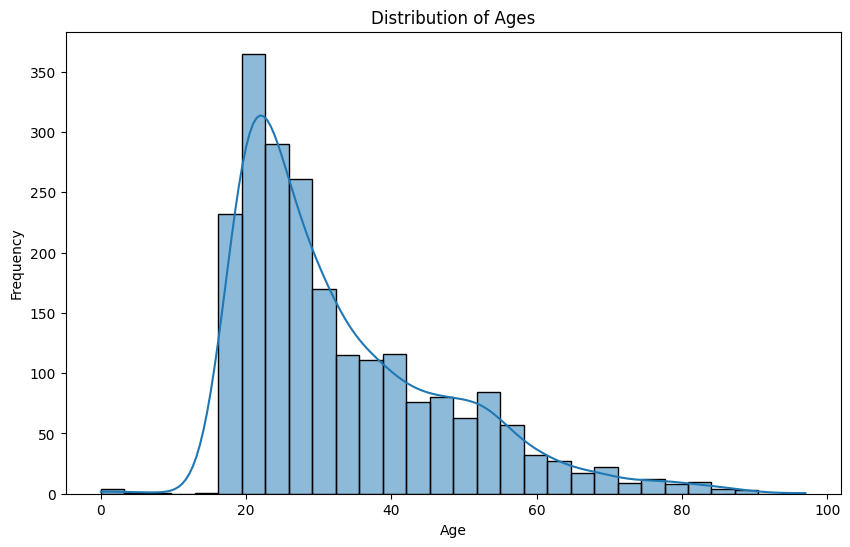

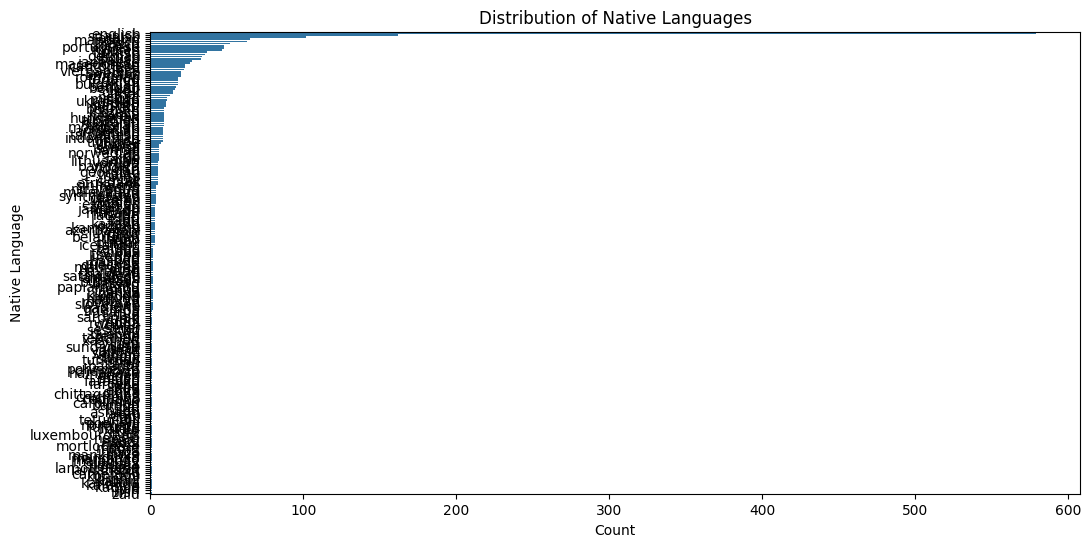

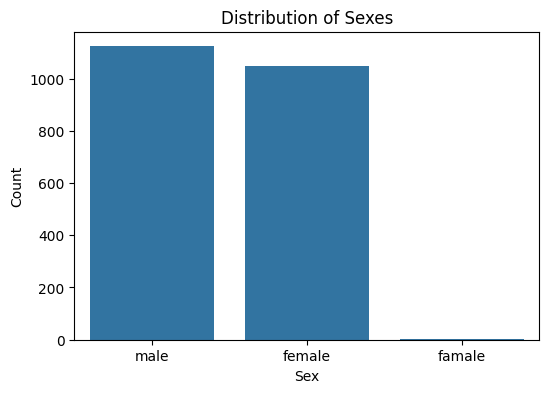

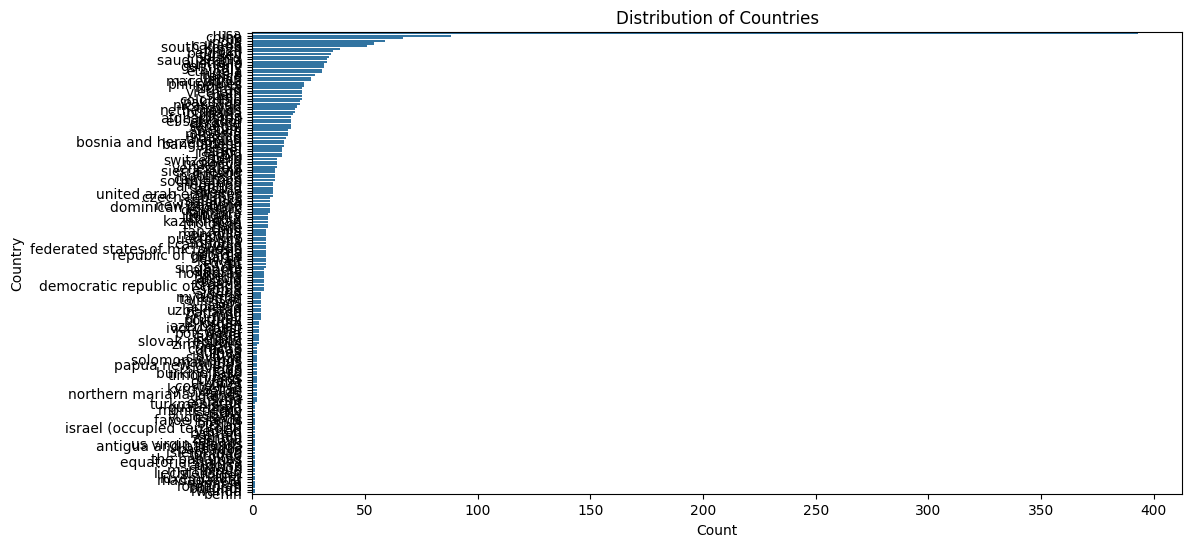

In [ ]:
# Display basic information about the metadata
print("Metadata Info:")
print(metadata.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(metadata.describe())

# Display the distribution of categorical columns
print("\nDistribution of Categorical Columns:")
print(metadata['native_language'].value_counts())
print(metadata['sex'].value_counts())
print(metadata['country'].value_counts())

# Visualize the distribution of ages
plt.figure(figsize=(10, 6))
sns.histplot(metadata['age'], bins=30, kde=True)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of native languages
plt.figure(figsize=(12, 6))
sns.countplot(y='native_language', data=metadata, order=metadata['native_language'].value_counts().index)
plt.title('Distribution of Native Languages')
plt.xlabel('Count')
plt.ylabel('Native Language')
plt.show()

# Visualize the distribution of sexes
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=metadata)
plt.title('Distribution of Sexes')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of countries
plt.figure(figsize=(12, 6))
sns.countplot(y='country', data=metadata, order=metadata['country'].value_counts().index)
plt.title('Distribution of Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.show()

File: recordings/recordings/recordings/english468.mp3
Sample Rate: 44100
Duration: 22.720362811791382 seconds


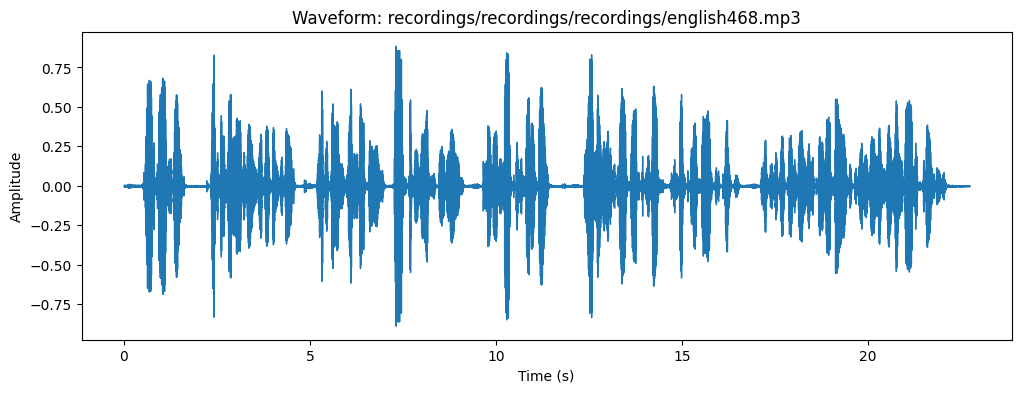

<ipython-input-15-f86c7214f620>:28: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


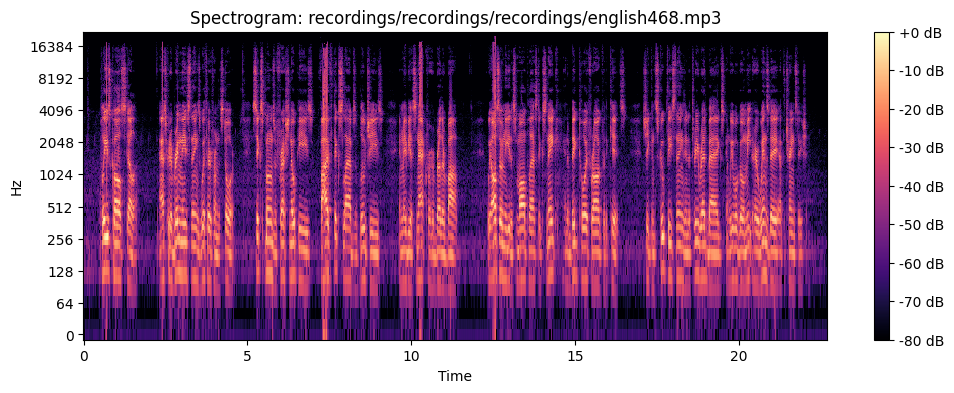

File: recordings/recordings/recordings/amharic10.mp3
Sample Rate: 44100
Duration: 48.021043083900224 seconds


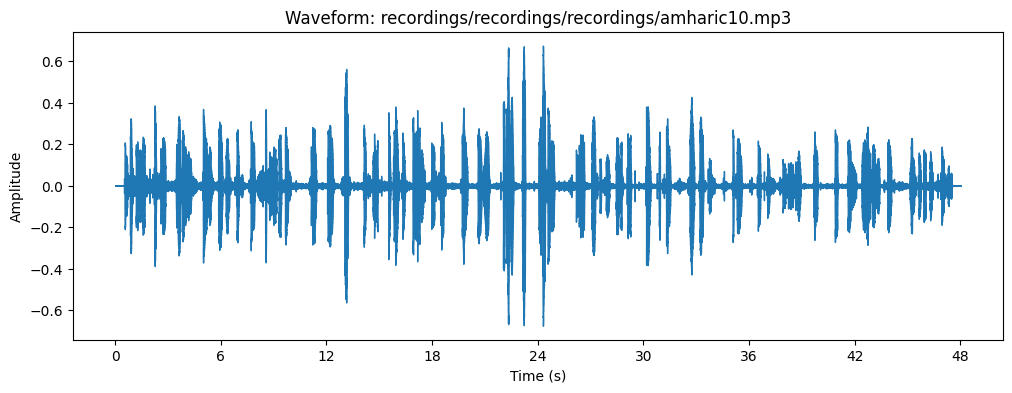

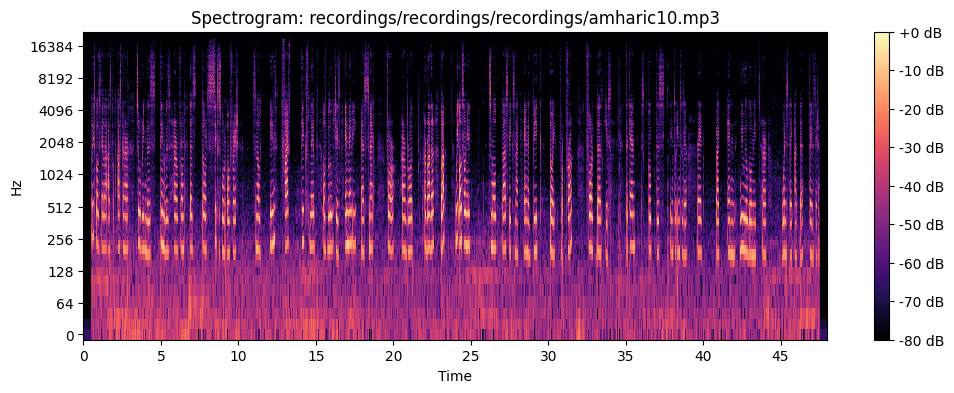

File: recordings/recordings/recordings/english317.mp3
Sample Rate: 48000
Duration: 24.286666666666665 seconds


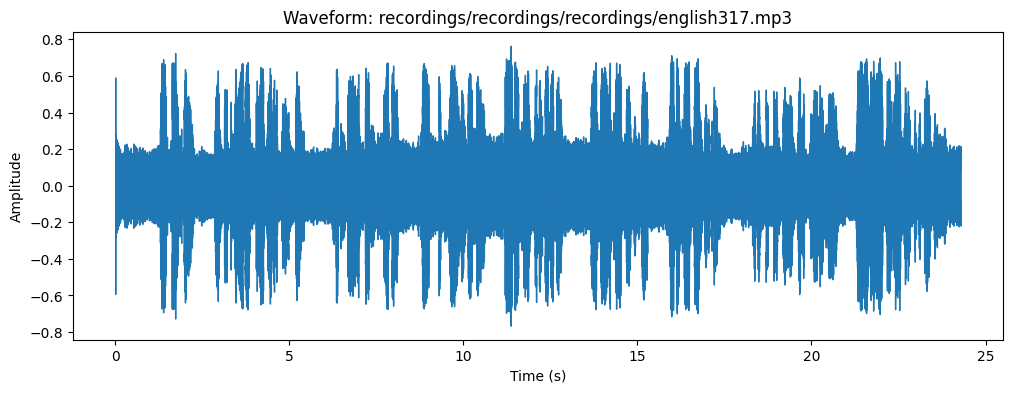

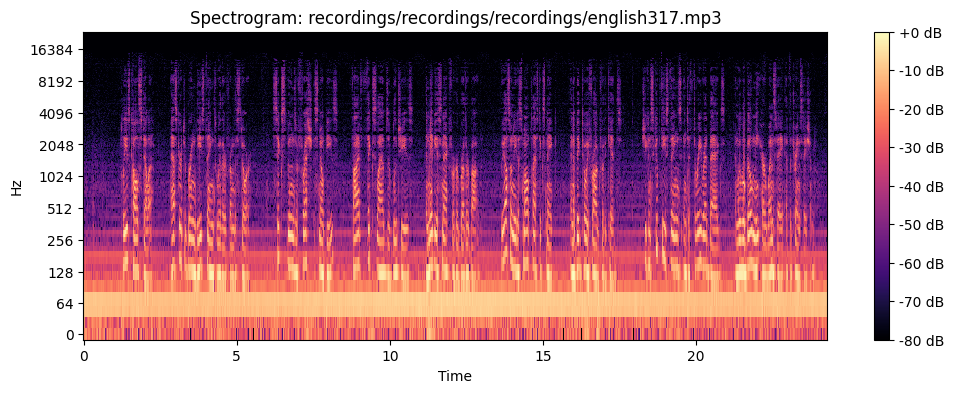

File: recordings/recordings/recordings/english208.mp3
Sample Rate: 48000
Duration: 24.515625 seconds


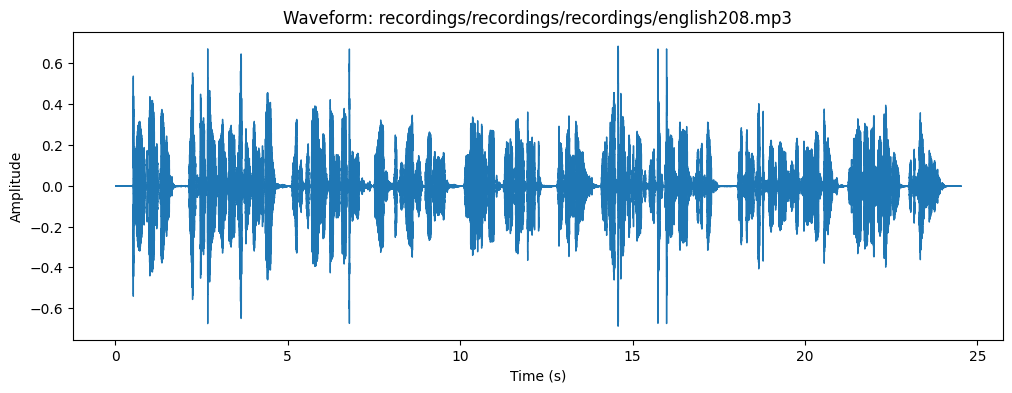

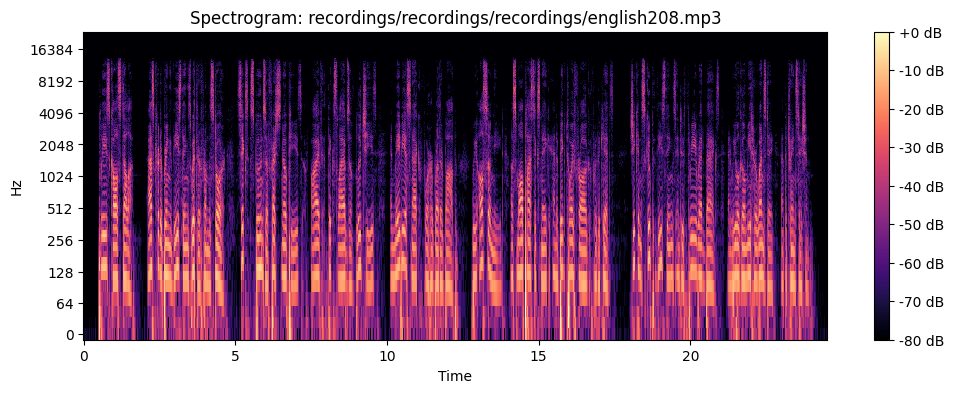

File: recordings/recordings/recordings/pashto9.mp3
Sample Rate: 44100
Duration: 49.136326530612244 seconds


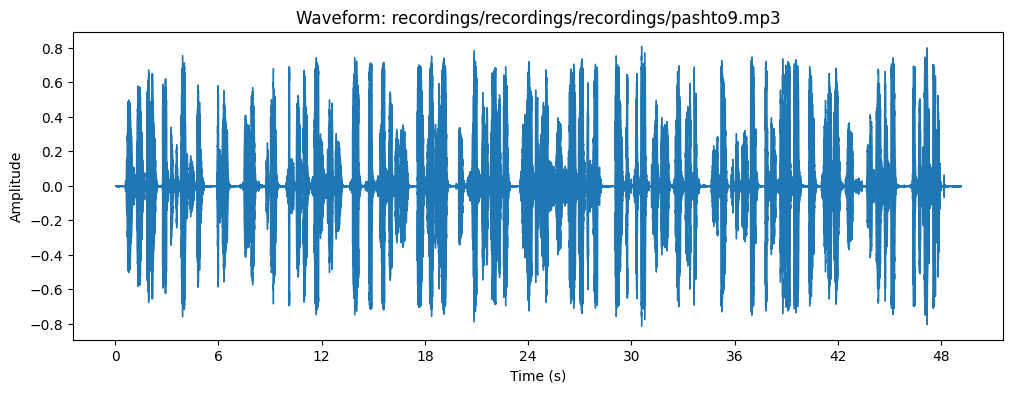

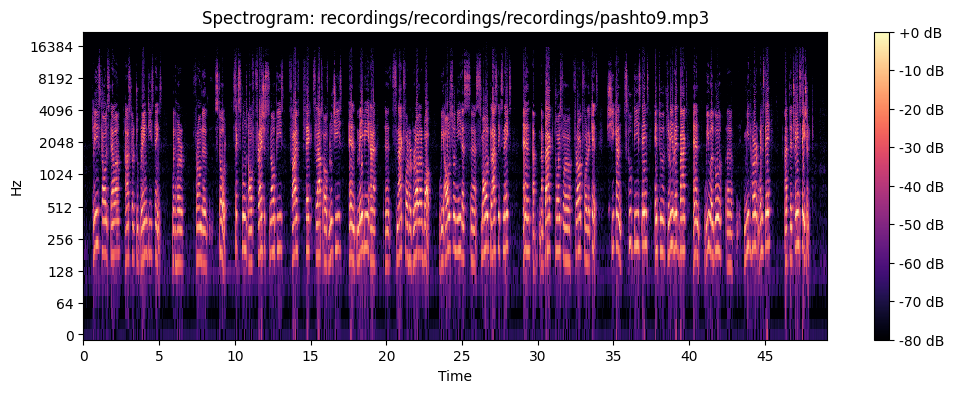

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Function to load and analyze an audio file
def analyze_audio(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        # basic info
        print(f"File: {file_path}")
        print(f"Sample Rate: {sr}")
        print(f"Duration: {librosa.get_duration(y=y, sr=sr)} seconds")

        # plot waveform
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform: {file_path}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

        # plot spectrogram
        plt.figure(figsize=(12, 4))
        D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram: {file_path}')
        plt.show()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Recordings directory
audio_dir = "recordings/recordings/recordings"

if os.path.exists(audio_dir):
    # list of files in directory
    all_files = os.listdir(audio_dir)

    valid_audio_extensions = ['.wav', '.mp3', '.flac']
    audio_files = [f for f in all_files if os.path.splitext(f)[1].lower() in valid_audio_extensions]

    # first 5 audio files
    for file in audio_files[:5]:
        file_path = os.path.join(audio_dir, file)
        analyze_audio(file_path)
else:
    print(f"Error: {audio_dir} folder not found.")

In [ ]:
import pandas as pd

# load metadata
metadata_path = "recordings/speakers_all.csv"
metadata = pd.read_csv(metadata_path)

# display metadata head
print("Metadata Columns:", metadata.columns)
print(metadata.head())

# missing values check
print("Missing Values:")
print(metadata.isnull().sum())

metadata = metadata.dropna(subset=['filename', 'country'])

metadata['filename'] = metadata['filename'].apply(lambda x: x.strip() + '.mp3')  # Adjust extension if needed

# unique countries
print("\nUnique Countries:")
print(metadata['country'].unique())

Metadata Columns: Index(['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex',
       'speakerid', 'country', 'file_missing?', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11'],
      dtype='object')
    age  age_onset              birthplace  filename native_language   sex  \
0  24.0       12.0         koussi, senegal   balanta         balanta  male   
1  18.0       10.0          buea, cameroon  cameroon        cameroon  male   
2  48.0        8.0  hong, adamawa, nigeria  fulfulde        fulfulde  male   
3  42.0       42.0   port-au-prince, haiti   haitian         haitian  male   
4  40.0       35.0   port-au-prince, haiti   haitian         haitian  male   

   speakerid   country  file_missing?  Unnamed: 9  Unnamed: 10 Unnamed: 11  
0        788   senegal           True         NaN          NaN         NaN  
1       1953  cameroon           True         NaN          NaN         NaN  
2       1037   nigeria           True         NaN          NaN         NaN  
3   

<ipython-input-16-633187a9c2be>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['filename'] = metadata['filename'].apply(lambda x: x.strip() + '.mp3')  # Adjust extension if needed


In [ ]:
import os

# directory containing audio files
audio_dir = "recordings/recordings/recordings"

# new column for the full path to the audio file
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(audio_dir, x))

# check if the audio files exist
metadata['file_exists'] = metadata['filepath'].apply(os.path.exists)

metadata = metadata[metadata['file_exists']]

print("\nMetadata with Audio File Paths:")
print(metadata.head())


Metadata with Audio File Paths:
     age  age_onset                         birthplace        filename  \
32  27.0        9.0             virginia, south africa  afrikaans1.mp3   
33  40.0        5.0             pretoria, south africa  afrikaans2.mp3   
34  43.0        4.0  pretoria, transvaal, south africa  afrikaans3.mp3   
35  26.0        8.0             pretoria, south africa  afrikaans4.mp3   
36  19.0        6.0            cape town, south africa  afrikaans5.mp3   

   native_language     sex  speakerid       country  file_missing?  \
32       afrikaans  female          1  south africa          False   
33       afrikaans    male          2  south africa          False   
34       afrikaans    male        418  south africa          False   
35       afrikaans    male       1159  south africa          False   
36       afrikaans    male       1432  south africa          False   

    Unnamed: 9  Unnamed: 10 Unnamed: 11  \
32         NaN          NaN         NaN   
33         NaN 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import IPython.display as ipd
import librosa
import librosa.display
from collections import Counter

# Cleaned metadata
metadata = pd.read_csv("recordings/metadata_wav.csv")

# Display basic information
print(f"Total samples: {len(metadata)}")
print(f"Number of unique native languages: {metadata['native_language'].nunique()}")
print(f"Number of unique countries: {metadata['country'].nunique()}")
print(f"Number of unique birthplaces: {metadata['birthplace'].nunique()}")

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Top 15 languages by sample count
top_languages = metadata['native_language'].value_counts().head(15)
plt.subplot(1, 3, 1)
sns.barplot(y=top_languages.index, x=top_languages.values)
plt.title('Top 15 Native Languages')
plt.xlabel('Number of Samples')
plt.tight_layout()

# Top 15 countries by sample count
top_countries = metadata['country'].value_counts().head(15)
plt.subplot(1, 3, 2)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title('Top 15 Countries')
plt.xlabel('Number of Samples')
plt.tight_layout()

# Age distribution
plt.subplot(1, 3, 3)
sns.histplot(metadata['age'].dropna(), bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.tight_layout()

plt.savefig('dataset_distribution.png')
plt.figure(figsize=(10, 6))

# Gender distribution
gender_counts = metadata['sex'].value_counts()
plt.subplot(1, 2, 1)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')

# Age of English onset distribution
plt.subplot(1, 2, 2)
sns.histplot(metadata['age_onset'].dropna(), bins=20, kde=True)
plt.title('Age of English Onset Distribution')
plt.xlabel('Age of English Onset')
plt.tight_layout()

plt.savefig('demographic_distribution.png')

# Dataset imbalance
print("\nClass imbalance analysis:")
print("\nNative Language distribution:")
lang_counts = metadata['native_language'].value_counts()
print(f"Most common language: {lang_counts.index[0]} with {lang_counts.values[0]} samples")
print(f"Least common language: {lang_counts.index[-1]} with {lang_counts.values[-1]} samples")
print(f"Imbalance ratio: {lang_counts.values[0] / lang_counts.values[-1]:.2f}:1")

print("\nCountry distribution:")
country_counts = metadata['country'].value_counts()
print(f"Most common country: {country_counts.index[0]} with {country_counts.values[0]} samples")
print(f"Least common country: {country_counts.index[-1]} with {country_counts.values[-1]} samples")
print(f"Imbalance ratio: {country_counts.values[0] / country_counts.values[-1]:.2f}:1")

# native_language and country
language_country_map = metadata.groupby('native_language')['country'].agg(lambda x: Counter(x).most_common(1)[0])
language_country_df = pd.DataFrame(language_country_map.tolist(), index=language_country_map.index, columns=['most_common_country', 'count'])

print("\nRelationship between language and country:")
print(language_country_df.head(10))

def plot_audio_sample(wav_path, title):
    y, sr = librosa.load(wav_path, sr=None)
    plt.figure(figsize=(12, 4))

    # Waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"{title} - Waveform")

    # Spectrogram
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} - Spectrogram")

    plt.tight_layout()
    return plt

languages_to_sample = metadata['native_language'].value_counts().head(3).index
for lang in languages_to_sample:
    sample = metadata[metadata['native_language'] == lang].sample(1).iloc[0]
    fig = plot_audio_sample(sample['wav_path'], f"{lang} ({sample['country']})")
    fig.savefig(f'audio_sample_{lang}.png')
    display(ipd.Audio(sample['wav_path']))

In [ ]:
# Count English and Non-English native languages
english_count = (metadata['native_language'] == 'english').sum()
non_english_count = len(metadata) - english_count

# Calculate percentages
total_samples = len(metadata)
english_percentage = (english_count / total_samples) * 100
non_english_percentage = (non_english_count / total_samples) * 100

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie([english_count, non_english_count],
        labels=['English', 'Non-English'],
        autopct='%1.1f%%',
        colors=['#1E90FF', '#FF6347'])
plt.title('Native Language Distribution: English vs Non-English')
plt.savefig('english_distribution_pie.png')

# Print detailed statistics
print("Native Language Distribution:")
print(f"Total Samples: {total_samples}")
print(f"English Samples: {english_count} ({english_percentage:.2f}%)")
print(f"Non-English Samples: {non_english_count} ({non_english_percentage:.2f}%)")
print(f"English to Non-English Ratio: {english_count/non_english_count:.2f}:1")

# Detailed breakdown of non-English languages
non_english_breakdown = metadata[metadata['native_language'] != 'english']['native_language'].value_counts()
print("\nTop 10 Non-English Languages:")
print(non_english_breakdown.head(10))

### Audio Conversion and Machine Learning Tests

In [ ]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
from pydub import AudioSegment

def convert_to_wav(mp3_path, wav_path):
    try:
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")
        print(f"Converted {mp3_path} to {wav_path}")
    except Exception as e:
        print(f"Error converting {mp3_path}: {e}")

# Convert all mp3 files to wav
for idx, row in metadata.iterrows():
    mp3_path = row['filepath']
    if mp3_path.endswith('.mp3'):
        wav_path = mp3_path.replace('.mp3', '.wav')
        convert_to_wav(mp3_path, wav_path)
        metadata.at[idx, 'filepath'] = wav_path

Converted recordings/recordings/recordings/afrikaans1.mp3 to recordings/recordings/recordings/afrikaans1.wav
Converted recordings/recordings/recordings/afrikaans2.mp3 to recordings/recordings/recordings/afrikaans2.wav
Converted recordings/recordings/recordings/afrikaans3.mp3 to recordings/recordings/recordings/afrikaans3.wav
Converted recordings/recordings/recordings/afrikaans4.mp3 to recordings/recordings/recordings/afrikaans4.wav
Converted recordings/recordings/recordings/afrikaans5.mp3 to recordings/recordings/recordings/afrikaans5.wav
Converted recordings/recordings/recordings/agni1.mp3 to recordings/recordings/recordings/agni1.wav
Converted recordings/recordings/recordings/akan1.mp3 to recordings/recordings/recordings/akan1.wav
Converted recordings/recordings/recordings/albanian1.mp3 to recordings/recordings/recordings/albanian1.wav
Converted recordings/recordings/recordings/albanian2.mp3 to recordings/recordings/recordings/albanian2.wav
Converted recordings/recordings/recordings/

In [ ]:
import librosa
import numpy as np

# Function to extract MFCC features from an audio file
def extract_mfcc(filepath, n_mfcc=13):
    y, sr = librosa.load(filepath, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Extract MFCC features for each audio file
metadata['mfcc'] = metadata['filepath'].apply(extract_mfcc)

# Display the updated metadata with MFCC features
print("\nMetadata with MFCC Features:")
print(metadata.head())


Metadata with MFCC Features:
     age  age_onset                         birthplace        filename  \
32  27.0        9.0             virginia, south africa  afrikaans1.mp3   
33  40.0        5.0             pretoria, south africa  afrikaans2.mp3   
34  43.0        4.0  pretoria, transvaal, south africa  afrikaans3.mp3   
35  26.0        8.0             pretoria, south africa  afrikaans4.mp3   
36  19.0        6.0            cape town, south africa  afrikaans5.mp3   

   native_language     sex  speakerid       country  file_missing?  \
32       afrikaans  female          1  south africa          False   
33       afrikaans    male          2  south africa          False   
34       afrikaans    male        418  south africa          False   
35       afrikaans    male       1159  south africa          False   
36       afrikaans    male       1432  south africa          False   

    Unnamed: 9  Unnamed: 10 Unnamed: 11  \
32         NaN          NaN         NaN   
33         NaN    

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode country
label_encoder = LabelEncoder()
metadata['country_encoded'] = label_encoder.fit_transform(metadata['country'])

# Prepare
X = np.array(metadata['mfcc'].tolist())
y = metadata['country_encoded'].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes
print("\nShapes of Datasets:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Shapes of Datasets:
X_train: (1706, 13)
X_test: (427, 13)
y_train: (1706,)
y_test: (427,)


In [ ]:
import numpy as np

# Save the prepared data
np.save("recordings/X_train.npy", X_train)
np.save("recordings/X_test.npy", X_test)
np.save("recordings/y_train.npy", y_train)
np.save("recordings/y_test.npy", y_test)

import joblib
joblib.dump(label_encoder, "recordings/label_encoder.pkl")

['recordings/label_encoder.pkl']

In [ ]:
!pip install transformers datasets torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 666.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
import numpy as np

# Load pre-trained wav2vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Function to extract wav2vec2 embeddings from a .wav file
def extract_wav2vec2_embeddings(filepath):
    try:
        # load audio file and resample to 16kHz for wav2vec2
        audio_input, _ = librosa.load(filepath, sr=16000)

        inputs = processor(audio_input, return_tensors="pt", sampling_rate=16000)

        with torch.no_grad():
            outputs = model(**inputs)

        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None

# Extract embeddings for all audio files
metadata['wav2vec2_embeddings'] = metadata['filepath'].apply(extract_wav2vec2_embeddings)

metadata = metadata.dropna(subset=['wav2vec2_embeddings'])

# Display the updated metadata
print(metadata.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

X = np.array(metadata['wav2vec2_embeddings'].tolist())
y = metadata['country_encoded'].values

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network classifier
class CountryClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CountryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]  # dimension of wav2vec2 embeddings
num_classes = len(np.unique(y_train))  # number of unique countries
model = CountryClassifier(input_dim, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

#### Possible models and datasets

In [ ]:
# Load metadata
metadata_path = "LJSpeech/LJSpeech-1.1/metadata.csv"
if os.path.exists(metadata_path):
    metadata = pd.read_csv(metadata_path, sep='|', header=None, names=['ID', 'Transcription', 'Normalized Transcription'])
    print("Metadata loaded successfully!")
    print(metadata.head())
else:
    print(f"Error: {metadata_path} not found. Check your directory structure.")

# List available audio files
def list_audio_files(directory):
    """Lists all audio files in a dataset directory."""
    audio_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav") or file.endswith(".mp3"):
                audio_files.append(os.path.join(root, file))
    return audio_files

# Process Audio Files
def process_audio(audio_path, target_sr=16000):
    """Loads an audio file, converts it to mono, resamples, and trims silence."""
    audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)
    audio = librosa.effects.trim(audio)[0]  # trim silence
    return audio, sr

# Convert MP3 to WAV
def convert_to_wav(audio_path, target_dir):
    """Converts MP3 files to WAV using torchaudio."""
    wav_path = os.path.join(target_dir, os.path.splitext(os.path.basename(audio_path))[0] + ".wav")
    waveform, sample_rate = torchaudio.load(audio_path)
    torchaudio.save(wav_path, waveform, sample_rate)
    return wav_path

Metadata loaded successfully!
           ID                                      Transcription  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-0005  the invention of movable metal letters in the ...   

                            Normalized Transcription  
0  Printing, in the only sense with which we are ...  
1                     in being comparatively modern.  
2  For although the Chinese took impressions from...  
3  produced the block books, which were the immed...  
4  the invention of movable metal letters in the ...  
Metadata Sample:
           ID                                      Transcription  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0

In [ ]:
import os
import librosa
import torchaudio
import pandas as pd
import requests
import zipfile
import shutil
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

# Possible datasets
datasets = {
    "CommonVoice": "https://commonvoice.mozilla.org/en/datasets",
    "SpeechAccentArchive": "https://accent.gmu.edu/",
    "VoxForge": "http://www.voxforge.org/home/downloads"
}

# Download function
def download_dataset(url, save_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB
    t = tqdm(total=total_size, unit='B', unit_scale=True)

    with open(save_path, 'wb') as f:
        for data in response.iter_content(block_size):
            t.update(len(data))
            f.write(data)
    t.close()

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)

# Create directory structure
base_dir = "/content/drive/MyDrive/Accent_Classification"
os.makedirs(base_dir, exist_ok=True)

datasets_paths = {
    "CommonVoice": os.path.join(base_dir, "CommonVoice"),
    "SpeechAccentArchive": os.path.join(base_dir, "SpeechAccentArchive"),
    "VoxForge": os.path.join(base_dir, "VoxForge")
}

for dataset, path in datasets_paths.items():
    os.makedirs(path, exist_ok=True)

print("Dataset directories created.")

Mounted at /content/drive
Dataset directories created.
Manually download from these sources:
CommonVoice: https://commonvoice.mozilla.org/en/datasets
SpeechAccentArchive: https://accent.gmu.edu/
VoxForge: http://www.voxforge.org/home/downloads
Found 0 audio files in CommonVoice dataset.
Setup complete. Proceed with manual dataset downloads and preprocessing.


In [ ]:
import kagglehub

path = kagglehub.dataset_download("rtatman/speech-accent-archive")

print("Path to dataset files:", path)

100%|██████████| 865M/865M [00:12<00:00, 70.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rtatman/speech-accent-archive/versions/2


#### British Isles Dataset

In [ ]:
from datasets import load_dataset
import IPython.display as ipd

sample_ds = load_dataset("ylacombe/english_dialects", "irish_male", split="train")

print(sample_ds[0])

# play sample audio
ipd.Audio(sample_ds[0]["audio"]["array"], rate=sample_ds[0]["audio"]["sampling_rate"])


{'line_id': 'BI0057', 'audio': {'path': 'irm_02484_00388340153.wav', 'array': array([-1.22070312e-04, -1.52587891e-04, -1.22070312e-04, ...,
        1.52587891e-04,  9.15527344e-05,  1.83105469e-04]), 'sampling_rate': 48000}, 'text': 'It is thirteen degrees with drizzle in Exeter', 'speaker_id': 2484}
